## Objective

This notebook will get you started with training the benchmark object detection model for detecting the potholes. 

* Download the training dataset: https://datahack.analyticsvidhya.com/contest/dataverse-hack/download/train-file
* Download the test dataset: https://datahack.analyticsvidhya.com/contest/dataverse-hack/download/test-file

**Note**: 

1. We recommend you to run the notebook on google colab since it is developed on the google colab.

2. Ensure to add the appropriate path names to read the image names and annotation files if you are running locally.

3. Change the runtime to GPU for quick results.


**Steps to Implement Faster RCNN**

1. Import requires libraries and load data
2. Data Preprocessing
3. Defining model architecture
4. Testing the model

In [1]:
# mount google drive to access data zip files
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


**Import Libraries**

In [2]:
# import required libraries
import os
import numpy as np
import pandas as pd
import torch
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# for importing custom functions
import sys
sys.path.append('/content/gdrive/MyDrive/dataverse_hackathon_submission/functions')

from tqdm import tqdm


In [3]:
# import custom scripts
import augment

In [4]:
# unzip the data
#!unzip 'train.zip'
#!unzip '/content/gdrive/MyDrive/dataverse_hackathon_submission/train.zip' > /dev/null

# unzip augmented data
!unzip '/content/gdrive/MyDrive/dataverse_hackathon/train_data_aug_5.zip' > /dev/null

In [5]:
#!unzip 'test.zip'
!unzip '/content/gdrive/MyDrive/dataverse_hackathon_submission/test.zip' > /dev/null

In [6]:
# Constants
EXPERIMENTS_PATH = '/content/gdrive/MyDrive/dataverse_hackathon_submission/experiments'
MODEL_PATH = '/content/gdrive/MyDrive/dataverse_hackathon_submission/model'

NUM_EPOCHS = 5
BATCH_SIZE = 8

RANDOM_STATE = 123
torch.manual_seed(RANDOM_STATE)

**Data Preprocessing**

In [8]:
# reading csv file
# data = pd.read_csv('train/labels.csv')
data = pd.read_csv('train/labels_aug.csv')
# store copy of original data prior to any augmentation added
data_copy = data.copy()

data.head()

,ImageID,LabelName,XMin,XMax,YMin,YMax
0,1.jpg,pothole,0.0,131.0,140.0,263.0
1,1.jpg,pothole,168.0,487.0,279.0,449.0
2,1.jpg,pothole,1.0,144.0,34.0,109.0
3,2.jpg,pothole,57.0,952.0,271.0,505.0
4,3.jpg,pothole,225.0,416.0,292.0,439.0


In [9]:
aug_count = input('Num. augmentations to generate: ')
aug_count = int(aug_count)
if aug_count > 0:
    for img in os.listdir('train/images/'):
        img_aug, bbss = augment.augment_image('train/images/',
                                              img,
                                              data,
                                              aug_count)
        data = augment.save_augmentation(img_aug,
                                         bbss,
                                         img,
                                         data,
                                         'train/images/')
    data.to_csv('train/labels_aug.csv', index=False, encoding='utf-8')
    print('Augmented files added to training folder.')

Num. augmentations to generate: 0


In [10]:
# # zip training folder containing augmented data
# os.chdir('train')
# !zip -r /content/train.zip /content/train
# os.chdir('..')

In [11]:
data['LabelName'] = data['LabelName'].replace({'pothole': 1})

In [12]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [13]:
# defining required transformations
from torchvision import transforms as TF

transform = TF.Compose([
    TF.Resize((224, 224)),
    TF.ToTensor()
])

In [14]:
# defining class to load data
class PotHoleDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None,train=True):
        self.root = root
        self.transforms = transforms
        # load all image files
        self.imgs = os.listdir(root)
        if '.ipynb_checkpoints' in self.imgs:
          self.imgs.remove('.ipynb_checkpoints')
        self.train = train

    def __getitem__(self, idx):
        # load images

        img_name = self.imgs[idx]
        img_path = os.path.join(self.root, img_name)
        img = Image.open(img_path)
        if self.train == False:
          if self.transforms is not None:
            img = self.transforms(img)
          return img,img_name
        else:
          h, w = np.array(img).shape[:2]
          num_objs = data[data['ImageID'] == img_name].shape[0]
          boxes = []
          cell_type = []
          for i in range(num_objs):
              xmin = data[data['ImageID'] == img_name]['XMin'].iloc[i]
              xmax = data[data['ImageID'] == img_name]['XMax'].iloc[i]
              ymin = data[data['ImageID'] == img_name]['YMin'].iloc[i]
              ymax = data[data['ImageID'] == img_name]['YMax'].iloc[i]
              target = data[data['ImageID'] == img_name]['LabelName'].iloc[i]
              boxes.append([xmin, ymin, xmax, ymax])
              cell_type.append(target)
          # convert everything into a torch.Tensor
          boxes = torch.as_tensor(boxes, dtype=torch.float32)
          labels = torch.as_tensor(cell_type, dtype=torch.int64)

          target = {}
          target["boxes"] = boxes
          target["labels"] = labels
          #print(boxes)
          if self.transforms is not None:
              img = self.transforms(img)
              boxes[:, 0] = boxes[:, 0] * (224/w)
              boxes[:, 2] = boxes[:, 2] * (224/w)
              boxes[:, 1] = boxes[:, 1] * (224/h)
              boxes[:, 3] = boxes[:, 3] * (224/h)

          return img, target

    def __len__(self):
        return len(self.imgs)

In [15]:
dataset = PotHoleDataset('train/images/', transforms=transform)

In [16]:
## convert list of list to tuple
def collate_fn(batch):
    return tuple(zip(*batch))

In [17]:
# defining data loader
data_loader = torch.utils.data.DataLoader(
    dataset, 
    batch_size=BATCH_SIZE, # 8, 
    shuffle=True, 
    collate_fn=collate_fn
)

In [18]:
# testing for one iteration
for batch_x, batch_y in data_loader:
    break

In [19]:
batch_x[0].shape

torch.Size([3, 224, 224])

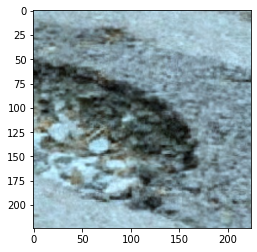

In [20]:
plt.imshow(np.transpose(batch_x[0], (1, 2, 0)))

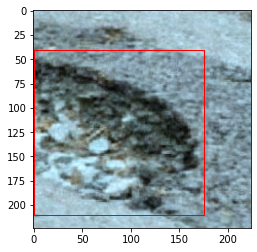

In [21]:
# plot bounding box
plt.axes()
plt.imshow(np.transpose(batch_x[0], (1, 2, 0)))
for i in range(len(batch_y[0]['boxes'])):
    bbox = batch_y[0]['boxes'][i]
    x1, y1 = bbox[0], bbox[1]
    x2, y2 = bbox[2], bbox[3]
    if batch_y[0]['labels'][i] == 1:
        color = 'red'

    rectangle = plt.Rectangle((x1,y1), x2-x1, y2-y1, fc='none',ec=color)
    plt.gca().add_patch(rectangle)
plt.show()


**Defining the model**

In [22]:
# define model
model = fasterrcnn_resnet50_fpn(pretrained=True)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

In [23]:
# # freeze pretrained model weights prior to training
# for param in model.parameters():
# 	param.requires_grad = False

model

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [24]:
num_classes = 2

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [25]:

# check model on one image
model.eval()
output = model(batch_x[5].view(1, 3, 224, 224))

In [26]:
output

[{'boxes': tensor([[  2.5992,  75.0340,  55.0488, 212.4390],
          [  0.0000,  49.2812,  30.9671, 210.5510],
          [ 89.9159, 121.9365,  96.6568, 126.2396],
          [  0.0000,  80.9209,  16.9495, 213.7746],
          [  0.4437,   2.4674, 125.3859, 194.8548],
          [  5.2253,   0.0000,  52.9704,  98.1309],
          [  0.0000,   0.0000,  15.2073, 101.1167],
          [156.1998, 108.1988, 168.3437, 112.9210],
          [155.0988, 105.1973, 167.1125, 114.2147],
          [  0.0000,  73.5487, 181.5233, 176.3720],
          [ 17.0170,  71.0718,  87.4466, 185.3653],
          [  0.0000,  36.5241,  23.5993, 110.5469],
          [  0.0000,  89.4662, 109.2245, 214.0519],
          [157.4606, 170.6963, 167.2171, 179.6452],
          [  0.7992,  72.5846,  36.5147, 105.2804],
          [  0.0000, 138.0121,  46.7937, 217.4559],
          [ 13.7214,   0.0000, 186.5193,  91.2076],
          [ 45.4858,  47.9757, 115.9776, 184.6208],
          [  0.0000,  44.9607,   9.6970, 116.5324],
   

In [27]:
#GPU if avilable
model = model.to(device)

In [28]:
# define optimization 
#optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0005)

In [29]:
# # define loss function - here we use a cross entropy loss
# # since we're defining if there is or is not an object present
# loss_fn = torch.nn.CrossEntropyLoss()

In [30]:
# set model to train
model.train()

# train model
for epoch in tqdm(range(NUM_EPOCHS)): #range(2):

    # initialize variables
    epoch_classif_loss = epoch_regress_loss = cnt = 0

    # loop through the data
    for batch_x, batch_y in data_loader:
        # get batch images and targets and transfer them to GPU if available
        batch_x = list(image.to(device) for image in batch_x)
        batch_y = [{k: v.to(device) for k, v in t.items()} for t in batch_y]

        # clear gradients
        optimizer.zero_grad()

        # pass images to model and get loss
        loss_dict = model(batch_x, batch_y)
        losses = sum(loss for loss in loss_dict.values())        

        # do a backward pass
        losses.backward()

        # update gradients
        optimizer.step()

        # sum loss and get count
        epoch_classif_loss += loss_dict['loss_classifier'].item()
        epoch_regress_loss += loss_dict['loss_box_reg'].item()
        cnt += 1

    # take average loss for all batches
    epoch_classif_loss /= cnt
    epoch_regress_loss /= cnt
    
    # print loss
    print("Training loss for epoch {} is {} for classification and {} for regression "
        .format(epoch + 1, epoch_classif_loss, epoch_regress_loss)
    )

 20%|██        | 1/5 [14:23<57:33, 863.44s/it]

Training loss for epoch 1 is 0.08390308285195003 for classification and 0.11717137459584069 for regression 


 40%|████      | 2/5 [28:40<42:59, 859.67s/it]

Training loss for epoch 2 is 0.061779969455174374 for classification and 0.09885709921627585 for regression 


 60%|██████    | 3/5 [42:58<28:38, 859.03s/it]

Training loss for epoch 3 is 0.0518280777924696 for classification and 0.08821740232511732 for regression 


 80%|████████  | 4/5 [57:18<14:19, 859.18s/it]

Training loss for epoch 4 is 0.04350411392392861 for classification and 0.07959076031213015 for regression 


100%|██████████| 5/5 [1:11:37<00:00, 859.59s/it]

Training loss for epoch 5 is 0.037118329429558325 for classification and 0.07205712185361632 for regression 


In [31]:
# save base model
torch.save(model.state_dict(), os.path.join(MODEL_PATH, 'aug_5_epochs_sgd_2', 'resnet_aug_5_epoch_sgd_2.pt'))

**Model Evaluation**

In [32]:
test_dataset = PotHoleDataset('test/images/', transforms=transform,train=False)

In [33]:
# defining data loader
data_loader_test = torch.utils.data.DataLoader(
    test_dataset, 
    batch_size=BATCH_SIZE, # 8, 
    shuffle=True
)

In [34]:
my_submission = pd.DataFrame()
model.eval()
for batch_test,names in data_loader_test:
  output = model(batch_test.to(device))
  output = [{k: v.to("cpu") for k, v in t.items()} for t in output]
  temp = pd.DataFrame()
  for i in range(len(output)):
    boxes = output[i]['boxes'].detach().numpy()
    scores = output[i]['scores'].detach().numpy()
    labels = output[i]['labels'].detach().numpy()
    scores = np.expand_dims(scores, axis=1)
    labels = np.expand_dims(labels, axis=1)
    batch_df = pd.DataFrame(np.hstack((boxes,scores,labels)),columns=['XMin','YMin','XMax','YMax','Conf','LabelName'])
    batch_df['ImageID'] = names[i]
    img = cv2.imread('/content/test/images/'+names[i])
    h,w = img.shape[:2]
    batch_df['LabelName'] = 'pothole'
    batch_df['XMax'] = batch_df['XMax']/224 * w
    batch_df['XMin'] = batch_df['XMin']/224 * w
    batch_df['YMax'] = batch_df['YMax']/224 * h
    batch_df['YMin'] = batch_df['YMin']/224 * h
    batch_df['XMax'] = batch_df['XMax'].astype(int)
    batch_df['XMin'] = batch_df['XMin'].astype(int)
    batch_df['YMax'] = batch_df['YMax'].astype(int)
    batch_df['YMin'] = batch_df['YMin'].astype(int)
    temp = pd.concat([batch_df,temp])
  my_submission = pd.concat([my_submission,temp])

In [35]:
# save model
my_submission.to_csv(os.path.join(EXPERIMENTS_PATH, 'aug_5_epochs_sgd_2','resnet_aug_5_epoch_sgd_2.csv'),index=False)

In [36]:
my_submission.head(10)

,XMin,YMin,XMax,YMax,Conf,LabelName,ImageID
0,7,51,381,254,0.998826,pothole,890.jpg
0,192,258,431,395,0.995894,pothole,1094.jpg
0,172,141,446,275,0.990723,pothole,889.jpg
1,299,107,349,133,0.983930,pothole,889.jpg
2,28,209,116,276,0.968405,pothole,889.jpg
3,49,143,141,204,0.967382,pothole,889.jpg
4,1,123,53,151,0.942261,pothole,889.jpg
5,0,99,32,126,0.662376,pothole,889.jpg
6,150,115,192,139,0.614772,pothole,889.jpg
7,82,125,107,136,0.433190,pothole,889.jpg


In [37]:
# inspect a random sample of test images and their predicting bounding boxes
from google.colab.patches import cv2_imshow
import random

test_images = [file for file in os.listdir('/content/test/images') 
                                    if file.lower().endswith('.jpg')]
random.seed(RANDOM_STATE)
test_samples = random.sample(test_images, 10)

for img in test_samples:
    test_img = cv2.imread(os.path.join('/content/test/images', img))
    test_img_pred = test_img.copy()

    for idx, row in my_submission[my_submission.ImageID == img].iterrows():
        x1 = row.XMin
        y1 = row.YMin
        x2 = row.XMax
        y2 = row.YMax
        cv2.rectangle(test_img_pred,
                    (x1, y1),
                    (x2, y2),
                    (0,0,255),
                    2)
    cv2_imshow(test_img_pred)

Output hidden; open in https://colab.research.google.com to view.

In [38]:
data.LabelName.value_counts()

1    7340
Name: LabelName, dtype: int64